In [61]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, OrdinalEncoder
from sklearn.metrics import classification_report,  confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
df = pd.read_csv('../data/steam.csv')

In [63]:
# Convert owner range into numeric averages

def owners_to_num(x):
    low, high = x.split("-")
    return (int(low) + int(high)) / 2

df["owners_num"] = df["owners"].apply(owners_to_num)

In [64]:
# Drop unnecessary columns

df = df.drop(columns=['appid', 'name', 'release_date', 'developer', 'publisher', 'platforms', 'owners'], errors='ignore')

In [65]:
# Top 5 playtime

df['average_playtime'].sort_values(ascending=0).head(5)

9201    190625
1478     95245
6014     95242
8969     63481
3930     55204
Name: average_playtime, dtype: int64

In [66]:
# drop the outlier game

df = df.drop(df["average_playtime"].idxmax())

In [67]:
# Show summary statistics and percentiles for 'average_playtime'

df['average_playtime'].describe(percentiles=[0.25, 0.5, 0.75,0.8, 0.85, 0.9, 0.99])

count    27074.000000
mean       142.769594
std       1413.517634
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
80%         17.000000
85%        137.000000
90%        244.000000
99%       2121.700000
max      95245.000000
Name: average_playtime, dtype: float64

In [68]:
# Creat new column playtime_group with pandas cut

bins = [0, 1, 10, 50, 200, df['average_playtime'].max() + 1]
labels = ['Very Short', 'Short', 'Medium', 'Long', 'Addictive']

df['playtime_group'] = pd.cut(df['average_playtime'], bins=bins, labels=labels, include_lowest=True)

print(df['playtime_group'].value_counts())

print("\nPercentage per group:")
print(df['playtime_group'].value_counts(normalize=True) * 100)

playtime_group
Very Short    21061
Addictive      3446
Long           1467
Medium          682
Short           418
Name: count, dtype: int64

Percentage per group:
playtime_group
Very Short    77.790500
Addictive     12.728079
Long           5.418483
Medium         2.519022
Short          1.543917
Name: proportion, dtype: float64


# Encoding

In [69]:
# Encode playtime groups into ordered numeric values

categories = [['Very Short', 'Short', 'Medium', 'Long', 'Addictive']]
ordinal_encoder = OrdinalEncoder(categories=categories)
df['playtime_group_encoded'] = ordinal_encoder.fit_transform(df[['playtime_group']]).astype(int)

In [70]:
# Convert multi-value text columns into binary features using MultiLabelBinarizer

text_cols = ['categories', 'genres', 'steamspy_tags']
df_final = df.copy()

for col in text_cols:
    if col in df_final.columns:

        df_final[col] = df_final[col].fillna('').astype(str).str.split(';')
        mlb = MultiLabelBinarizer()

        encoded_cols = pd.DataFrame(
            mlb.fit_transform(df_final[col]),
            columns=[f"{col}_{c}" for c in mlb.classes_],
            index=df_final.index
        )
        df_final = pd.concat([df_final, encoded_cols], axis=1)
        df_final.drop(columns=[col], inplace=True)


# Decision Tree Classifier 

In [71]:
# Define the threshold for addictive games as the top 10% of playtime

playtime_original = df_final['average_playtime']
addictive_threshold = playtime_original.quantile(0.90)
addictive_threshold

np.float64(244.0)

In [72]:
# Create is_addictive column
df_final['is_addictive'] = (playtime_original > addictive_threshold).astype(int)

In [73]:
# Define X and y as the target (is_addictive)
X = df_final.drop(columns=['average_playtime', 'is_addictive', 'median_playtime', 'english', 'price', 'required_age', 'playtime_group'], errors='ignore')
y = df_final['is_addictive']

In [74]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
# Training
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [76]:
# Predection
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"(Accuracy): {accuracy:.4f}")

(Accuracy): 0.9692


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7304
           1       0.80      0.93      0.86       819

    accuracy                           0.97      8123
   macro avg       0.90      0.95      0.92      8123
weighted avg       0.97      0.97      0.97      8123



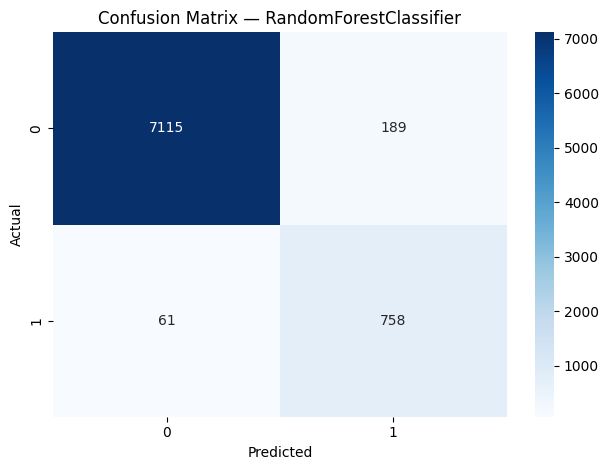

In [77]:
# Display the classification report and visualize the confusion matrix for model evaluation

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — RandomForestClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


                                   Feature  Importance
4                   playtime_group_encoded    0.897497
1                         positive_ratings    0.029478
3                               owners_num    0.011260
2                         negative_ratings    0.010327
0                             achievements    0.009300
47                            genres_Indie    0.003229
21   categories_Partial Controller Support    0.003197
112                   steamspy_tags_Casual    0.003104
36                        genres_Adventure    0.002544
285                   steamspy_tags_Puzzle    0.002355


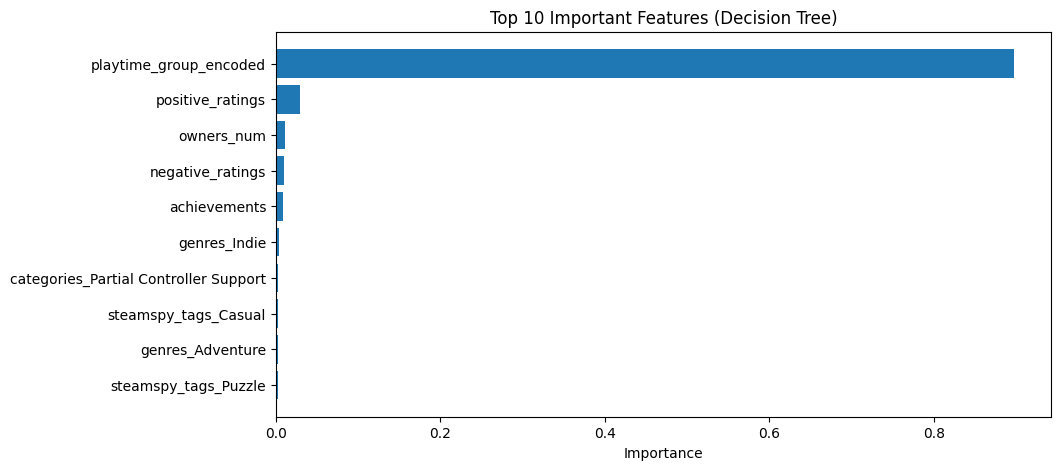

In [78]:
# Calculate and visualize the top 10 feature importances from the Decision Tree model

feature_names = X_train.columns

importances = dt_model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp.head(10))

plt.figure(figsize=(10,5))
plt.barh(feat_imp['Feature'].head(10), feat_imp['Importance'].head(10))
plt.gca().invert_yaxis()
plt.title('Top 10 Important Features (Decision Tree)')
plt.xlabel('Importance')
plt.show()

# Test the model

In [79]:
# Create a new game for testing

new_game = pd.DataFrame([{
    'english': 1,
    'required_age': 0,
    'categories': 'Single-player;Online Multi-Player',
    'genres': 'Action;Shooter',
    'steamspy_tags': 'Multiplayer;First-Person;Shooter',
    'achievements': 20,
    'positive_ratings': 7000,
    'negative_ratings': 400,
    'average_playtime': 25000,
    'median_playtime': 1800,
    'price': 10,
    'owners_num': 800000,
    'playtime_group': 'Addictive'
}])

In [80]:
# Encode text columns (categories, genres, steamspy_tags) using the trained MultiLabelBinarizer

text_cols = ['categories', 'genres', 'steamspy_tags']
for col in text_cols:
    if col in new_game.columns:
        new_game[col] = new_game[col].astype(str).str.split(';')

for col in text_cols:
    encoded = pd.DataFrame(mlb.transform(new_game[col]),
                           columns=[f"{col}_{c}" for c in mlb.classes_],
                           index=new_game.index)
    new_game = pd.concat([new_game.drop(columns=[col]), encoded], axis=1)

/home/shatha/.pyenv/versions/Game_Addictiveness/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Online Multi-Player', 'Single-player'] will be ignored
  warnings.warn(


In [81]:
# Encode playtime_group using OrdinalEncoder and drop the original column

new_game['playtime_group_encoded'] = ordinal_encoder.transform(new_game[['playtime_group']]).astype(int)
new_game.drop(columns=['playtime_group'], inplace=True)

In [82]:
# Ensure new_game has the same columns

for col in X_train.columns:
    if col not in new_game.columns:
        new_game[col] = 0
new_game = new_game[X_train.columns]

In [83]:
# Make prediction and get probability for the new game

prediction = dt_model.predict(new_game)
proba = dt_model.predict_proba(new_game)

In [84]:

print("Predicted Class:", "Addictive" if prediction[0] == 1 else "Not Addictive")
print(f"Probability of Not Addictive: {proba[0][0]*100:.2f}%")
print(f"Probability of Addictive: {proba[0][1]*100:.2f}%")

Predicted Class: Addictive
Probability of Not Addictive: 0.53%
Probability of Addictive: 99.47%


In [85]:
df_original = pd.read_csv('../data/steam.csv')
outlier_game = df_original["average_playtime"].idxmax()
df_original = df_original.drop(df_original["average_playtime"].idxmax())

pred_all = dt_model.predict(X)


In [86]:
df_original.shape

(27074, 18)

In [87]:
pred_all.shape

(27074,)

In [88]:
df_original["is_addictive"] = pred_all

In [89]:
df_original["is_addictive"]

0        1
1        1
2        0
3        1
4        1
        ..
27070    0
27071    0
27072    0
27073    0
27074    0
Name: is_addictive, Length: 27074, dtype: int64

In [90]:
df_original.to_csv("../data/game_addictiveness.csv", index=False)